In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
from einops import rearrange
import torch.nn.functional as F
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def save_reconstructed_image(outputs, save_path):
    outputs = outputs.cpu().numpy().clip(0, 1)
    outputs = (outputs * 255).astype(np.uint8)
    pil_image = Image.fromarray(outputs)
    pil_image.save(save_path)

<font size=6>Importing the Image</font>

In [23]:
img = torchvision.io.read_image("IMG.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


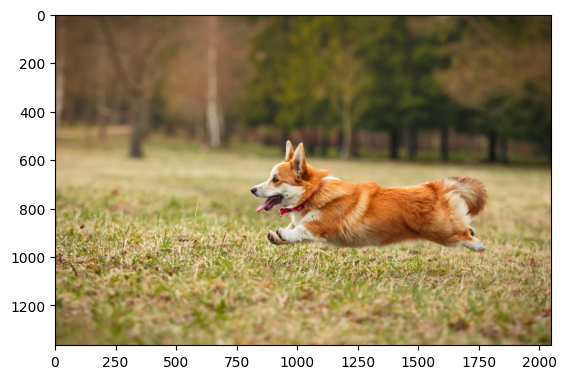

In [24]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [25]:
img

tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         ...,
         [121, 121, 122,  ...,  97,  96,  96],
         [121, 121, 122,  ...,  97,  97,  96],
         [121, 121, 122,  ...,  98,  97,  97]],

        [[ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         ...,
         [103, 103, 104,  ...,  82,  81,  81],
         [103, 103, 104,  ...,  82,  82,  81],
         [103, 103, 104,  ...,  83,  82,  82]],

        [[ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         ...,
         [ 37,  37,  38,  ...,  43,  42,  42],
         [ 37,  37,  38,  ...,  43,  43,  42],
         [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8)

<font size=6>Preprocessing the Image</font>

In [26]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
print((scaler_img))
img_scaled = torch.tensor(scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape))
print(img_scaled)

# img_scaled = torch.tensor(img_scaled)

type(torch.tensor(img_scaled))

MinMaxScaler()
tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1

C:\Users\Student\AppData\Local\Temp\ipykernel_26032\1585807756.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  type(torch.tensor(img_scaled))


torch.Tensor

In [27]:
# crop_200 = torchvision.transforms.functional.crop(img_scaled.cpu(), 610, 820, 200, 200)
# print(crop_200.shape)
# plt.imshow(rearrange(crop_200, 'c h w -> h w c').cpu().numpy())

torch.Size([3, 400, 400])


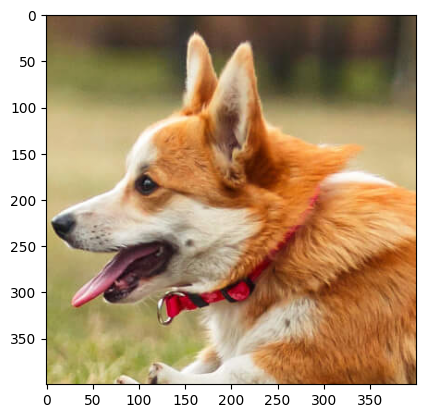

In [31]:
crop_400 = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 800, 400, 400)
print(crop_400.shape)
plt.imshow(rearrange(crop_400, 'c h w -> h w c').cpu().numpy())

size: torch.Size([3, 200, 200])


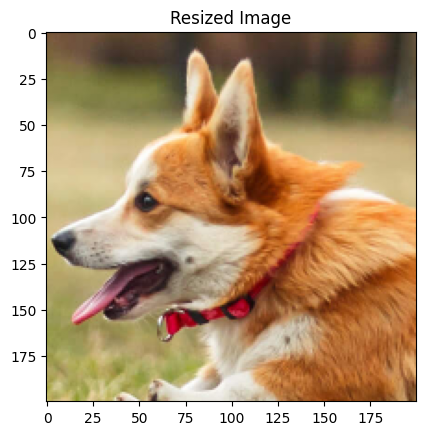

In [37]:
crop_400_np = crop_400.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) to (H, W, C)
import cv2
width = 200
height = 200
dim = (width, height)

resized_np = cv2.resize(crop_400_np, dim, interpolation=cv2.INTER_LINEAR)  # Resizing with interpolation

resized = torch.tensor(resized_np).permute(2, 0, 1)  # Convert (H, W, C) to (C, H, W)
print(f"size: {resized.shape}")
plt.imshow(rearrange(resized, 'c h w -> h w c').cpu().numpy())
plt.title("Resized Image")
plt.show()

MADE THE HIGH RESOLUTION IMAGE TO LOW RESOLUTION BY REDUCING ITS SIZE

In [39]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    
    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

COORDINATE MAP OF LOW RESOLUTION 200 x 200 IMAGE

In [40]:
dog_X, dog_Y = create_coordinate_map(resized)
dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [41]:
print(dog_X[:10, :], '\n', dog_Y[:10, :])

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) 
 tensor([[0.4569, 0.3353, 0.2255],
        [0.4569, 0.3353, 0.2255],
        [0.4569, 0.3353, 0.2255],
        [0.4569, 0.3353, 0.2255],
        [0.4471, 0.3216, 0.2235],
        [0.4471, 0.3216, 0.2235],
        [0.4471, 0.3216, 0.2235],
        [0.4471, 0.3216, 0.2235],
        [0.4412, 0.3157, 0.2176],
        [0.4412, 0.3157, 0.2176]])


In [42]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()

In [43]:
dog_X_scaled.shape, dog_X_scaled[:10, :]

(torch.Size([40000, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9899],
         [-1.0000, -0.9799],
         [-1.0000, -0.9698],
         [-1.0000, -0.9598],
         [-1.0000, -0.9497],
         [-1.0000, -0.9397],
         [-1.0000, -0.9296],
         [-1.0000, -0.9196],
         [-1.0000, -0.9095]]))

In [44]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()
def plot_reconstructed_and_original_image(original_img, net, X, title = "", scale = 1, allowSave = False, fileName = None):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    height *= scale
    width *= scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        
    fig = plt.figure(figsize = (8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    if allowSave and fileName:
        save_reconstructed_image(outputs, fileName)
        
    fig.suptitle(title, y = 0.9)
    plt.tight_layout()
from sklearn.kernel_approximation import RBFSampler
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [45]:
X_rff = create_rff_features(dog_X_scaled, 30000, 0.008)

In [46]:
from PIL import Image
X_rff.shape

torch.Size([40000, 30000])

In [47]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.01, X_rff, dog_Y, 200)

Epoch 0 loss: 0.314300
Epoch 100 loss: 0.013208


0.00548726599663496

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07213003..1.1735636].


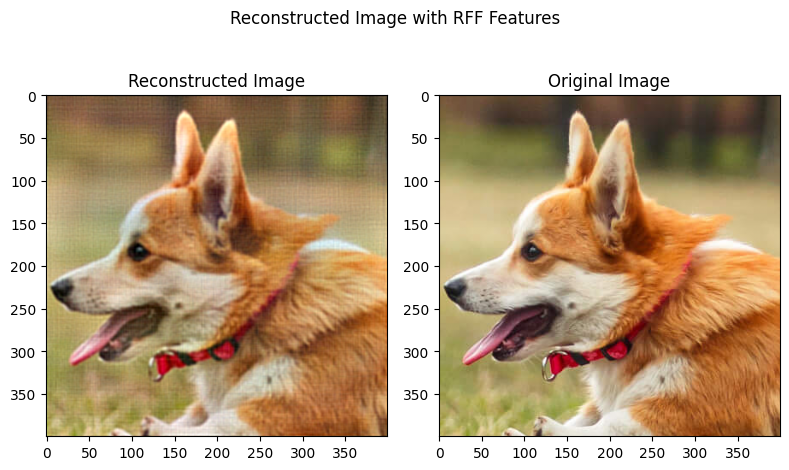

In [66]:
plot_reconstructed_and_original_image(crop_400, net, X_rff, title = "Reconstructed Image with RFF Features", scale = 1, allowSave = True, fileName = "re.png")
# plt.imshow(rearrange(crop_400, 'c h w -> h w c').cpu().numpy())

In [49]:
import gc
del X_rff
torch.cuda.empty_cache()
gc.collect()

6568

In [53]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [55]:
dog_X, dog_Y = create_coordinate_map(resized, scale = 2)
print(dog_X.shape, dog_Y.shape)

torch.Size([160000, 2]) torch.Size([40000, 3])


In [57]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
print(dog_X_scaled.shape)
print(dog_X_scaled[:10, :])

torch.Size([160000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        [-1.0000, -0.9850],
        [-1.0000, -0.9799],
        [-1.0000, -0.9749],
        [-1.0000, -0.9699],
        [-1.0000, -0.9649],
        [-1.0000, -0.9599],
        [-1.0000, -0.9549]])


In [58]:
X_rff = create_rff_features(dog_X_scaled, 30000, 0.008)
print(X_rff.shape)

torch.Size([160000, 30000])


In [63]:
print(crop_400.shape)

torch.Size([3, 400, 400])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07213003..1.1735636].


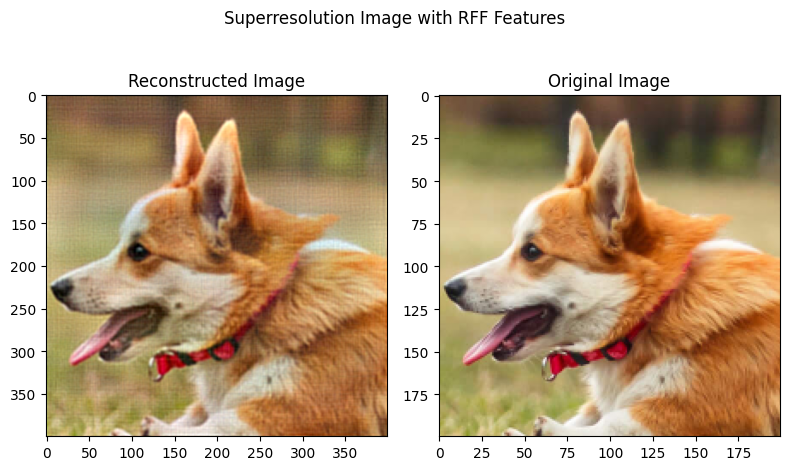

In [61]:
plot_reconstructed_and_original_image(resized, net, X_rff, title = "Superresolution Image with RFF Features", scale = 2, allowSave = True, fileName = "Superresolution.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07213003..1.1735636].


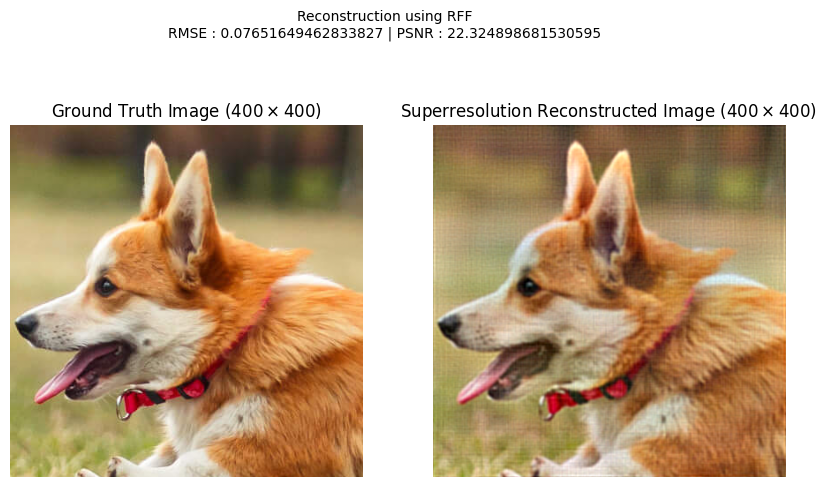

In [67]:
def metrics(img1, img2, max_value = 1.0):
    rmse = torch.sqrt(F.mse_loss(img1, img2))
    psnr_value = 20 * torch.log10(max_value / rmse)
    return rmse, psnr_value.item()
def predict_plot(original_img, net, X):
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    
    rmse, psnr = metrics(original_img, rearrange(outputs, "h w c -> c h w"))
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw = {"width_ratios": [1, 1]}, figsize = (10, 6))
    fig.suptitle("Reconstruction using RFF" "\n" f"RMSE : {rmse} | PSNR : {psnr}", fontsize = 10)                                                  
    ax[0].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title(fr"Ground Truth Image $({height} \times {width})$")
    ax[0].axis("off")
    ax[1].imshow(outputs.cpu().detach().numpy())
    ax[1].set_title(fr"Superresolution Reconstructed Image $({height} \times {width})$")
    ax[1].axis("off")
    plt.show()
predict_plot(crop_400, net, X_rff)